In [177]:
import pandas as pd
import numpy as np

In [178]:
fips = '36061'

In [179]:
# Cleaning and retrieving mobility data

mob = pd.read_csv('applemobilitydata/applemobilitycleaned_county.csv')
mob = mob.loc[mob['fips'] == float(fips)]
cols = [0,2,3]
mob = mob.drop(mob.columns[cols], axis=1)

In [180]:
# Cleaning and retrieving symptoms data

sym = pd.read_csv('covidsymptoms/covidsymptoms_google.csv')
sym = sym.loc[sym['fips'] == float(fips)]
cols = [0,2,3]
sym = sym.drop(sym.columns[cols], axis=1)

In [181]:
# Cleaning and retrieving demographics data

dem = pd.read_csv('countydemographics/county_demographics.csv')
dem = dem.loc[dem['fips'] == float(fips)]
cols = [0,2,3,4,5,6,9,10,11]
dem = dem.drop(dem.columns[cols], axis=1)

In [182]:
# Cleaning and retrieving testing rate data

tes = pd.read_csv('testingrates/testing_rates_county.csv')
tes = tes.loc[tes['fips'] == float(fips)]
cols = [0]
tes = tes.drop(tes.columns[cols], axis=1)

In [183]:
# Cleaning and retrieving case data

cas = pd.read_csv('covidstats/confirmed_cases_county.csv')
cas = cas.loc[cas['fips'] == float(fips)]
cols = [0]
cas = cas.drop(cas.columns[cols], axis=1)

In [184]:
newX = pd.concat([mob,sym])
newX = newX.reset_index()
newX = newX.drop(newX.columns[[0,1]], axis=1)

newY = pd.concat([cas])
newY = newY.reset_index()
newY = newY.drop(newY.columns[[0,1]], axis=1)

In [185]:
newX = newX.T
newY = newY.T
newX = newX.fillna(0)
newY = newY.fillna(0)

In [186]:
X = newX[[0,1]]
y = newY[[0]]

In [187]:
# Moving averages

X[0] = X[0].rolling(window=4).mean().dropna()
X[1] = X[1].rolling(window=2).mean().dropna()

X[0] = X[0].shift(6).dropna()
X[1] = X[1].shift(4).dropna()

X = X[X.index.isin(y.index)]
y = y[y.index.isin(X.index)]
X = X.fillna(0)
y = y.fillna(0)

In [188]:
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

X = StandardScaler().fit_transform(X)
y = StandardScaler().fit_transform(y)
y = np.reshape(y, (y.shape[0],))

In [189]:
# Gaussian Process Regression

In [190]:
import sklearn.gaussian_process as gp
kernel = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RBF(10.0, (1e-3, 1e3))
regressor = gp.GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=0.1)

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
model = regressor.fit(X, y)

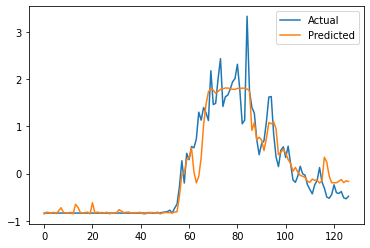

In [191]:
y_pred = regressor.predict(X)
df = pd.DataFrame({'Actual': y.flatten(), 'Predicted': y_pred.flatten()})
df.plot()

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(X)

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(y)